In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

import pathlib
import os
from scipy.stats import pearsonr
import seaborn as sb
from preprocessing_sequencing import preprocess_sequences as ps
from matplotlib import rcParams
import statistics
from final_processing import final_processing_functions as fpf
import ast
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from decimal import Decimal
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

In [3]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
proj_path = '/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/'

In [4]:
allen_comp_dict = {}
# Initialize an empty DataFrame to accumulate results for all mice
to_plot = pd.DataFrame()

for mouse in mice:
    parameters_path = proj_path + mouse + '/Sequencing'
    barcodes = pd.read_pickle(f'{parameters_path}/A1_barcodes_thresholded_with_source.pkl')
    #select only cortical samples
    parameters = fpf.load_parameters(directory=parameters_path)
    cortical_samples = parameters['cortical_samples']
    cortical_samples = [sample for sample in cortical_samples if sample in barcodes.columns]
    barcodes= barcodes[cortical_samples]
    failed_RT = barcodes.loc[:, (barcodes == 0).all()].columns
    barcodes.drop(columns=failed_RT, inplace=True)
    allen_comp_dict[mouse] = fpf.compare_to_allen(barcode_table=barcodes, parameters_path=str(parameters_path))
    
    # Create a temporary DataFrame to store data for the current mouse
    temp_df = pd.DataFrame({
        'Allen': np.log10(allen_comp_dict[mouse]['Mean_Allen'] + 1e-3),
        'MAPseq': np.log10(allen_comp_dict[mouse]['MAPseq_counts'] + 1e-3),
        'Mouse': mouse, 'Allen_expt_A': np.log10(allen_comp_dict[mouse]['Allen_expt_a'] + 1e-3), 'Allen_expt_B': np.log10(allen_comp_dict[mouse]['Allen_expt_b'] + 1e-3), 'Allen_expt_C': np.log10(allen_comp_dict[mouse]['Allen_expt_c'] + 1e-3),
    })
    
    # Calculate Z-scores for Allen and MAPseq
    temp_df['Allen_Z_core'] = (temp_df['Allen'] - temp_df['Allen'].mean()) / temp_df['Allen'].std()
    temp_df['MAPseq_Z_score'] = (temp_df['MAPseq'] - temp_df['MAPseq'].mean()) / temp_df['MAPseq'].std()
    temp_df['Allen_expt_A_Z_score'] = (temp_df['Allen_expt_A'] - temp_df['Allen_expt_A'].mean()) / temp_df['Allen_expt_A'].std()
    temp_df['Allen_expt_B_Z_score'] = (temp_df['Allen_expt_B'] - temp_df['Allen_expt_B'].mean()) / temp_df['Allen_expt_B'].std()
    temp_df['Allen_expt_C_Z_score'] = (temp_df['Allen_expt_C'] - temp_df['Allen_expt_C'].mean()) / temp_df['Allen_expt_C'].std()
    
    # Append the temp_df data to the main to_plot DataFrame
    to_plot = pd.concat([to_plot, temp_df], ignore_index=True)

Text(0.02, 0.98, 'r = 0.661, p = 3.83E-50')

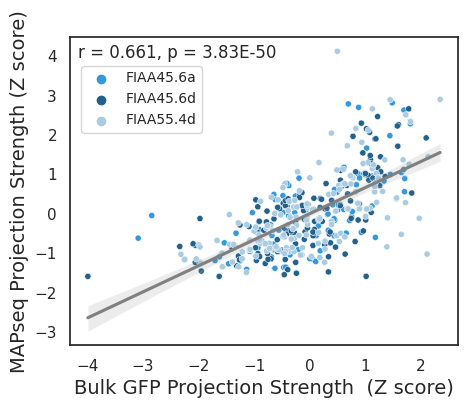

In [5]:

sb.set(font_scale=1, style='white')
sb.set_palette(['#3498DB', '#21618C', '#A9CCE3'])
plt.figure(figsize=(5, 4))

sb.scatterplot(data=to_plot, x="Allen_Z_core", y="MAPseq_Z_score", hue = 'Mouse', s=20)
sb.regplot(data=to_plot, x="Allen_Z_core", y="MAPseq_Z_score", scatter=False, color='grey')
# corr, p = pearsonr(
#     to_plot["Allen_Z_core"], y=to_plot["MAPseq_Z_score"]
# )
corr, p = pearsonr(to_plot["Allen_Z_core"], to_plot["MAPseq_Z_score"])
# plt.title(
#     f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}"
# )
plt.xlabel('Bulk GFP Projection Strength  (Z score)', size=14)
plt.ylabel('MAPseq Projection Strength (Z score)', size=14)
plt.legend(loc='upper left', fontsize='small', bbox_to_anchor=(0.01, 0.93))
plt.text(0.02, 0.98, f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')


In [8]:
import itertools
for A, B in itertools.combinations([0 ,1, 2], 2):
    print(A,B)

0 1
0 2
1 2


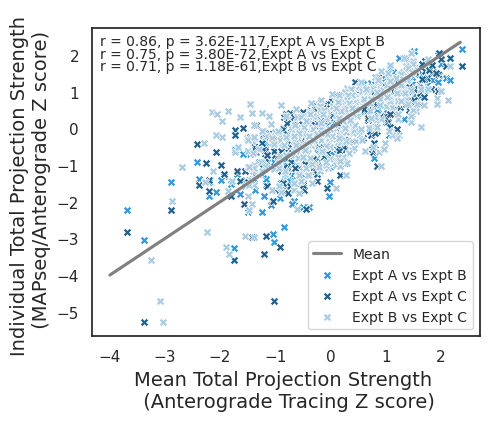

In [11]:
plt.figure(figsize=(5, 4))
# sb.scatterplot(data=to_plot, x="Allen_Z_core", y="Allen_expt_A_Z_score", color="#626567", label="Allen Expt A Z Score", marker="X")
# sb.scatterplot(data=to_plot, x="Allen_Z_core", y="Allen_expt_B_Z_score", color="#A6ACAF", label="Allen Expt B Z Score", marker="X")
# sb.scatterplot(data=to_plot, x="Allen_Z_core", y="Allen_expt_C_Z_score", color="slategrey", label="Allen Expt C Z Score", marker="X")
# sb.regplot(data=to_plot, x="Allen_expt_A_Z_score", y="Allen_expt_B_Z_score", scatter=False, color='grey')

height = 0.98
which_expt = ['Allen_expt_A_Z_score', 'Allen_expt_B_Z_score', 'Allen_expt_C_Z_score']
expt_name =['Expt A', 'Expt B', 'Expt C']
for A, B in itertools.combinations([0 ,1, 2], 2):
    sb.scatterplot(data=to_plot, x=which_expt[A], y=which_expt[B], label= f"{expt_name[A]} vs {expt_name[B]}", marker="X")
    corr, p = pearsonr(to_plot[which_expt[A]], to_plot[which_expt[B]])
    plt.text(0.02, height, f"r = {np.round(corr, 2)}, p = {Decimal(p):.2E},{expt_name[A]} vs {expt_name[B]} ", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    height = height-0.04
sb.regplot(data=to_plot, x="Allen_Z_core", y="Allen_Z_core", scatter=False, color='grey', label='Mean')
plt.xlabel('Mean Total Projection Strength \n (Anterograde Tracing Z score)', size=14)
plt.ylabel('Individual Total Projection Strength \n (MAPseq/Anterograde Z score)', size=14)
plt.legend(loc='lower right', fontsize='small')
# for i, which_expt in zip(['Allen_expt_A_Z_score', 'Allen_expt_B_Z_score', 'Allen_expt_C_Z_score'], ['Expt A', 'Expt B', 'Expt C']):
#     corr, p = pearsonr(to_plot[i], to_plot["Allen_expt_A_Z_score"])
#     plt.text(0.02, height, f"r = {np.round(corr, 2)}, p = {Decimal(p):.2E}, {which_expt} ", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
#     height = height-0.04

In case thresholding introduces artificially high r, let's look correlation with zeros removed

Now let's look at broad distribution

In [124]:
def combine_broad_regions(dataframe, regions_to_add):
    summed_data = {}
    for area, tubes in regions_to_add.items():
        valid_tubes = [
            tube for tube in tubes if tube in dataframe.columns
        ]
        summed_data[area] = dataframe[valid_tubes].sum(axis=1)

    df_result = pd.DataFrame(summed_data)
    df_result = df_result.loc[(df_result != 0).any(axis=1)]
    return df_result

In [113]:
samples_to_combine={}
mean_umi_tab= pd.DataFrame()
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
for i, mouse in enumerate(mice):
    which_samples = {}
    parameters_path = proj_path + mouse + '/Sequencing'
    # Load the barcode data for the current mouse
    barcodes = pd.read_pickle(f'{parameters_path}/A1_barcodes_thresholded.pkl')
    failed_RT = barcodes.loc[:, (barcodes == 0).all()].columns
    barcodes.drop(columns=failed_RT, inplace=True)
    parameters = ps.load_parameters(directory=parameters_path)
    #which_samples['Pons'] = parameters['pons_samples']
    which_samples['Ipsi Cortex'] = [sample for sample in parameters['cortical_samples'] if sample not in parameters['contra']]   
    which_samples['Contra Cortex'] = parameters['contra'] 
    which_samples['Striatum'] = parameters['striatum_samples']
    which_samples['Tectum'] = parameters['tectum_samples']
    which_samples['Thalamus'] = parameters['thalamus_samples']
    which_samples['IC'] = parameters['IC_samples']
    which_samples['SC'] = parameters['SC_samples']
    table_to_look = combine_broad_regions(dataframe=barcodes, regions_to_add=which_samples) 
    mean_umi_dict = {}
    for key in which_samples.keys():
            samples = [sample for sample in which_samples[key] if sample in barcodes.columns] 
            selection = barcodes[barcodes[samples].astype(bool).sum(axis=1)>0][samples].melt()
            values = [val for val in selection['value'] if val>0]
            mean_umi_dict[key] = np.mean(values)
    mean_umi_dict['mouse'] = mouse
    mean_umi_tab = mean_umi_tab.append(mean_umi_dict, ignore_index=True)
    if i == 0:
        combined_table = table_to_look
    else:
        combined_table = pd.concat([combined_table, table_to_look])
      

In [114]:
striatum_projecting = combined_table[combined_table["Striatum"] > 0]
PT_num = len(striatum_projecting[striatum_projecting[['Tectum', 'Thalamus']].astype(bool).astype(int).sum(axis=1)>0])
contra_num = len(striatum_projecting[striatum_projecting[['Contra Cortex']].astype(bool).astype(int).sum(axis=1)>0])
overlapping_num = len(striatum_projecting[(striatum_projecting[['Tectum', 'Thalamus']].astype(bool).astype(int).sum(axis=1)>0) & (striatum_projecting['Contra Cortex'].astype(bool).astype(int)>0)])
wrong_thal = len(striatum_projecting[(striatum_projecting['Thalamus'].astype(bool).astype(int)>0) & (striatum_projecting['Tectum'].astype(bool).astype(int)==0)])
print(f'number PT = {PT_num}, number contra IT = {contra_num}, number overlapping = {overlapping_num}, thal_not_tect= {wrong_thal}, tot_striatum = {len(striatum_projecting)}')

number PT = 302, number contra IT = 867, number overlapping = 3, thal_not_tect= 33, tot_striatum = 1994


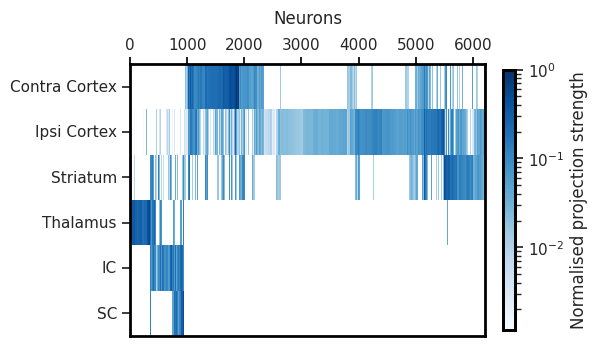

In [115]:
sb.set(font_scale=1, style='white')
areas_to_look = ['Ipsi Cortex','Contra Cortex', 'Striatum', 'IC', 'SC', 'Thalamus',]
combined_table_to_look = combined_table[areas_to_look]
cluster = sb.clustermap(
    combined_table_to_look.T,
    metric="braycurtis", row_cluster=True,
    standard_scale=0,
    norm=LogNorm(),
    cmap="Blues",
    figsize=(6, 4),
    xticklabels=False,
    yticklabels=True,
    cbar_pos=(0.8, 0.12, 0.02, 0.65), cbar_kws={'label': 'Normalised \n projection strength'}
)

cluster.ax_row_dendrogram.set_visible(False)
cluster.ax_col_dendrogram.set_visible(False)
cluster.ax_heatmap.yaxis.set_ticks_position('left')
cluster.ax_heatmap.yaxis.set_label_position('left')
cluster.ax_heatmap.set_xlabel('')  # Set empty string to remove x-axis label

# Add a border around the heatmap
for spine in cluster.ax_heatmap.spines.values():
    spine.set_visible(True)  # Make the spines visible
    spine.set_linewidth(2)   # Set border width
    spine.set_color('black') # Set border color
for spine in cluster.cax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)  # Set border width
    spine.set_color('black') 
cluster.cax.set_ylabel('Normalised projection strength', fontsize=12) 
num_barcodes = len(combined_table)
tick_positions = range(0, num_barcodes, 1000)
tick_labels = [str(pos) for pos in tick_positions]

# Set the x-tick labels on the heatmap
cluster.ax_heatmap.set_xticks(tick_positions)  # Set the position of the ticks
cluster.ax_heatmap.set_xticklabels(tick_labels, rotation=0)  # Set the tick labels
cluster.ax_heatmap.tick_params(axis='x', which='both', length=5, color='black')  # Ensure tick marks are visible

# Adjust the tick position in relation to the heatmap
cluster.ax_heatmap.xaxis.set_ticks_position('top')  # Move ticks to the top
cluster.ax_heatmap.xaxis.set_label_position('top')
cluster.ax_heatmap.set_xlabel('Neurons', fontsize=12, labelpad=10)
plt.show()

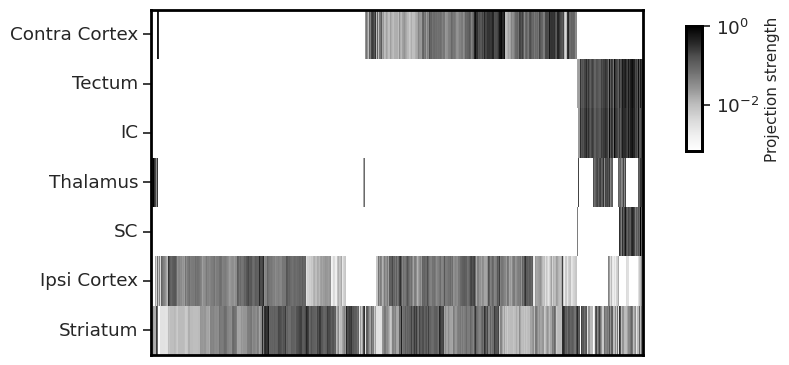

In [87]:
sb.set(font_scale=1.2, style='white')
cluster = sb.clustermap(
    striatum_projecting.T,
    metric="canberra",
    standard_scale=0,
    norm=LogNorm(),
    cmap="Greys",
    figsize=(8, 5),
    xticklabels=False,
    yticklabels=True,
    cbar_pos=(0.85, 0.5, 0.02, 0.25), cbar_kws={'label': 'Normalised \n projection strength'}
)

cluster.ax_row_dendrogram.set_visible(False)
cluster.ax_col_dendrogram.set_visible(False)
cluster.ax_heatmap.yaxis.set_ticks_position('left')
cluster.ax_heatmap.yaxis.set_label_position('left')
cluster.ax_heatmap.set_xlabel('')  # Set empty string to remove x-axis label

# Add a border around the heatmap
for spine in cluster.ax_heatmap.spines.values():
    spine.set_visible(True)  # Make the spines visible
    spine.set_linewidth(2)   # Set border width
    spine.set_color('black') # Set border color
for spine in cluster.cax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)  # Set border width
    spine.set_color('black') 
cluster.cax.set_ylabel('Projection strength', fontsize=11) 
plt.show()

In [116]:
IT = {}
PT = {}
CT = {}
layers = ['upper', 'lower']
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
    parameters = ps.load_parameters(directory=parameters_path)
    sample_vol_and_regions = pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
    sample_vol_and_regions['fractions'] = sample_vol_and_regions['breakdown'].apply(ast.literal_eval)
    sample_vol_and_regions['regions'] = sample_vol_and_regions['regions'].apply(ast.literal_eval)
    AUDp_containing = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    AUDp_containing = [sample for sample in AUDp_containing if sample in barcodes.columns]
    for layer in layers:
        if num == 0:
             IT[layer] = []
             CT[layer] = []
             PT[layer] = []
        new_dict[f'{layer}_layer'] = barcodes[barcodes.idxmax(axis=1).isin(parameters[f'{layer}_layer'])].drop(columns=AUDp_containing)
        IT[layer].append(len(new_dict[f'{layer}_layer'][(new_dict[f'{layer}_layer'][[f for f in parameters['cortical_samples'] if f in new_dict[f'{layer}_layer'].columns]].astype(bool).sum(axis=1)>0)&(new_dict[f'{layer}_layer'][[s for s in parameters['tectum_samples'] if s in new_dict[f'{layer}_layer'].columns]].astype(bool).sum(axis=1)==0) & (new_dict[f'{layer}_layer'][[s for s in parameters['thalamus_samples'] if s in new_dict[f'{layer}_layer'].columns]].astype(bool).sum(axis=1)==0)]))          
        PT[layer].append(len(new_dict[f'{layer}_layer'][new_dict[f'{layer}_layer'][[f for f in parameters['tectum_samples'] if f in new_dict[f'{layer}_layer'].columns]].astype(bool).sum(axis=1)>0]))
        CT[layer].append(len(new_dict[f'{layer}_layer'][(new_dict[f'{layer}_layer'][[s for s in parameters['tectum_samples'] if s in new_dict[f'{layer}_layer'].columns]].astype(bool).sum(axis=1)==0) & (new_dict[f'{layer}_layer'][[s for s in parameters['thalamus_samples'] if s in new_dict[f'{layer}_layer'].columns]].astype(bool).sum(axis=1)>0)]))
    
tot_IT_upper = np.sum(IT['upper'])
tot_IT_lower = np.sum(IT['lower'])
tot_PT_upper = np.sum(PT['upper'])
tot_CT_upper = np.sum(CT['upper'])
tot_PT_lower = np.sum(PT['lower'])
tot_CT_lower = np.sum(CT['lower'])

In [117]:
print(f'CT_upper = {tot_CT_upper}, PT_upper = {tot_PT_upper}, IT_upper={tot_IT_upper}')

CT_upper = 9, PT_upper = 52, IT_upper=1363


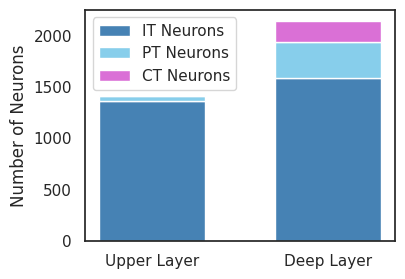

In [118]:


# Data
# tot_IT_upper = 544
# tot_IT_lower = 1090
# tot_PT_upper = 10
# tot_CT_upper = 0
# tot_PT_lower = 269
# tot_CT_lower = 115

# Data for plotting
layers = ['Upper Layer', 'Deep Layer']
IT_neurons = [tot_IT_upper, tot_IT_lower]
PT_neurons = [tot_PT_upper, tot_PT_lower]
CT_neurons = [tot_CT_upper, tot_CT_lower]

# Create the plot
fig, ax = plt.subplots(figsize=(4, 3))

# Stacked bar plot
bar_width = 0.6
ax.bar(layers, IT_neurons, label='IT Neurons', color='steelblue', width=bar_width)
ax.bar(layers, PT_neurons, bottom=IT_neurons, label='PT Neurons', color='skyblue' ,width=bar_width)
ax.bar(layers, CT_neurons, bottom=[i+j for i,j in zip(IT_neurons, PT_neurons)], label='CT Neurons', color='orchid', width=bar_width)

# Add labels and title
ax.set_ylabel('Number of Neurons')
#ax.set_title('CT, IT, and PT Neurons in Upper and Deep Layers')
ax.legend()

# Show the plot
plt.show()


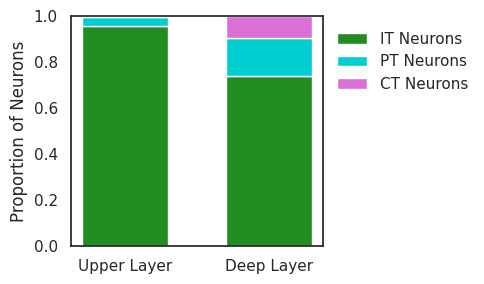

In [122]:
# Calculate total number of neurons in each layer
total_upper = tot_IT_upper + tot_PT_upper + tot_CT_upper
total_lower = tot_IT_lower + tot_PT_lower + tot_CT_lower

# Normalize the data to make the total neurons in each layer sum to 1
IT_neurons = [tot_IT_upper / total_upper, tot_IT_lower / total_lower]
PT_neurons = [tot_PT_upper / total_upper, tot_PT_lower / total_lower]
CT_neurons = [tot_CT_upper / total_upper, tot_CT_lower / total_lower]

# Data for plotting
layers = ['Upper Layer', 'Deep Layer']

# Create the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Stacked bar plot
bar_width = 0.6
ax.bar(layers, IT_neurons, label='IT Neurons', color='forestgreen', width=bar_width)
ax.bar(layers, PT_neurons, bottom=IT_neurons, label='PT Neurons', color='darkturquoise', width=bar_width)
ax.bar(layers, CT_neurons, bottom=[i+j for i,j in zip(IT_neurons, PT_neurons)], label='CT Neurons', color='orchid', width=bar_width)

# Add labels and title
ax.set_ylabel('Proportion of Neurons')
ax.set_ylim(0, 1)  # Set y-limit to ensure the bars are scaled from 0 to 1

# Move legend outside the plot (bottom right)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), frameon=False)

# Show the plot
plt.tight_layout()
plt.show()

Now plot correlations betwee mice

In [14]:
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
combined_mice_dict = {}
for mouse in mice:
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    failed_RT = barcodes.loc[:, (barcodes == 0).all()].columns
    barcodes.drop(columns=failed_RT, inplace=True)
    #normalise barcodes to total sum
    parameters=ps.load_parameters(directory=parameters_path)
    lcm_dir = parameters['lcm_directory']
    new_dict['homog_across_cubelet'] =fpf.homog_across_cubelet(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, dummy_data = False)
    new_dict['area_is_main'] =fpf.area_is_main(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False)
    new_dict['homog_across_area'] =fpf.homog_across_area(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False)
    new_dict['all_areas'] = fpf.get_area_volumes(barcode_table_cols = barcodes.columns, lcm_directory=lcm_dir)

    combined_mice_dict[mouse] = new_dict

In [15]:
analysis_list = ['homog_across_cubelet', 'homog_across_area', 'area_is_main']
corr_dict={}
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()
for key in analysis_list:
    correlation_matrix = pd.DataFrame(columns=mice, index=mice)
    for mouse_1 in mice:
        for mouse_2 in mice:
            if mouse_1 == mouse_2:
                correlation_matrix.loc[mouse_1, mouse_2] = np.nan
            else:
                common_columns = set(combined_mice_dict[mouse_1][key].columns).intersection(combined_mice_dict[mouse_2][key].columns)
                common_cols_cortex = []
                for col in common_columns:
                    if col != 'Contra':
                        structure = structure_tree.get_structures_by_acronym([col])
                        if 315 in structure[0]['structure_id_path']:
                            common_cols_cortex.append(col)
                    if col == 'Contra':
                        common_cols_cortex.append(col)
                mean_A = np.log10(combined_mice_dict[mouse_1][key][common_cols_cortex].mean(axis=0)+1e-10)
                mean_B = np.log10(combined_mice_dict[mouse_2][key][common_cols_cortex].mean(axis=0)+1e-10)
                corr, p = pearsonr(mean_A, mean_B)
                correlation_matrix.loc[mouse_1, mouse_2] = corr
                correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce')
            
    corr_dict[key] =correlation_matrix
            

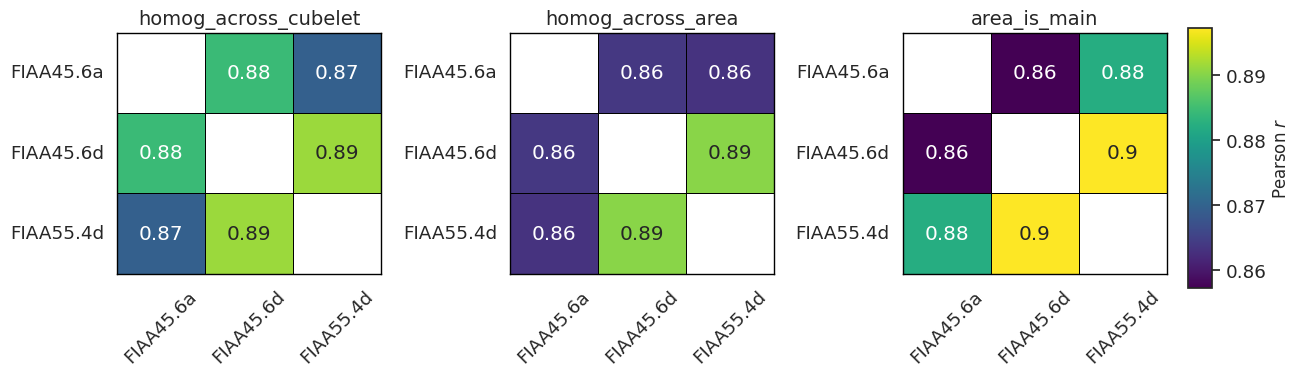

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
vmax =pd.concat(corr_dict.values()).max().max()
vmin =pd.concat(corr_dict.values()).min().min()
# Plot each correlation matrix as a heatmap
# for ax, (method, df) in zip(axes, corr_dict.items()):
  
#     sb.heatmap(df, ax=ax, cmap='viridis', annot=True, cbar=True, vmax = vmax, vmin = vmin)
#     ax.set_title(f'{method}')
#     #ax.set_xticks(rotation=90) 
#     #ax.set_
cbar_ax = fig.add_axes([1, 0.25, 0.02, 0.65])  # [left, bottom, width, height]

# Plot each correlation matrix as a heatmap
for ax, (method, df) in zip(axes, corr_dict.items()):
    sb.heatmap(df, ax=ax, cmap='viridis', annot=True, cbar=(ax == axes[-1]), vmax=vmax, vmin=vmin, 
               cbar_ax=None if ax != axes[-1] else cbar_ax, linewidths=0.5, linecolor='black')  # Add grid lines for separation
    ax.set_title(f'{method}', fontsize='14')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)
    
    # Add a black border around the heatmap and ensure all sides are visible
    for spine in ax.spines.values():
        spine.set_visible(True)  # Ensure all spines are visible
        spine.set_edgecolor('black')  # Set the border color to black
        spine.set_linewidth(1)  # Set the border width to 1

cbar_ax.spines['top'].set_visible(True)
cbar_ax.spines['bottom'].set_visible(True)
cbar_ax.spines['left'].set_visible(True)
cbar_ax.spines['right'].set_visible(True)
for spine in cbar_ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(1)
cbar = fig.colorbar(axes[-1].collections[0], cax=cbar_ax)
cbar.set_label(r'Pearson $r$', fontsize=12) 
plt.subplots_adjust(left=0.05, right=0.9, wspace=0.3)  
plt.tight_layout()
plt.show()

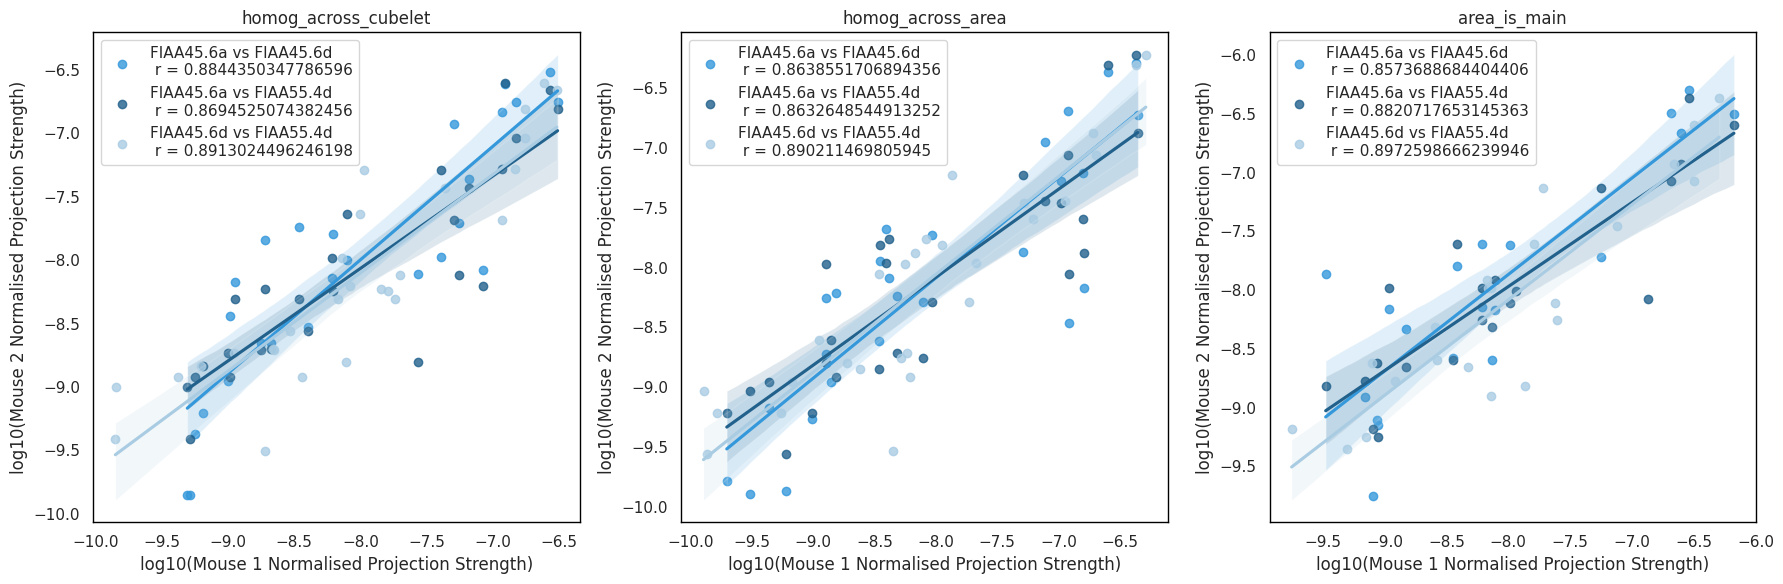

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
analysis_list = ['homog_across_cubelet', 'homog_across_area', 'area_is_main']
corr_dict={}
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()
for i, key in enumerate(analysis_list):
    #correlation_matrix = pd.DataFrame(columns=mice, index=mice)
    ax = axes[i]
    for mouse_1, mouse_2 in itertools.combinations(mice, 2):
        # for mouse_2 in mice:
        #     if mouse_1 == mouse_2:
        #         continue
        #     else:
        common_columns = set(combined_mice_dict[mouse_1][key].columns).intersection(combined_mice_dict[mouse_2][key].columns)
        common_cols_cortex = []
        for col in common_columns:
            if col != 'Contra':
                structure = structure_tree.get_structures_by_acronym([col])
                if 315 in structure[0]['structure_id_path']:
                    common_cols_cortex.append(col)
            if col == 'Contra':
                common_cols_cortex.append(col)
        mean_A = np.log10(combined_mice_dict[mouse_1][key][common_cols_cortex].mean(axis=0)+1e-10)
        mean_B = np.log10(combined_mice_dict[mouse_2][key][common_cols_cortex].mean(axis=0)+1e-10)
        corr, p = pearsonr(mean_A, mean_B)
        #sb.scatterplot(x=mean_A, y=mean_B, ax=ax, s=20, color='#3498DB', label='Data points')
        sb.regplot(x=mean_A, y=mean_B, ax=ax, scatter=True, label=f'{mouse_1} vs {mouse_2} \n r = {corr}')

    ax.set_xlabel('log10(Mouse 1 Normalised Projection Strength)', size=12)
    ax.set_ylabel('log10(Mouse 2 Normalised Projection Strength)', size=12)

    # Add a legend
    ax.legend(loc='upper left')
    ax.set_title(key)
    # Add a black border around the plot for visibility
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

# Adjust layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.9, wspace=0.3)
plt.tight_layout()
plt.show()

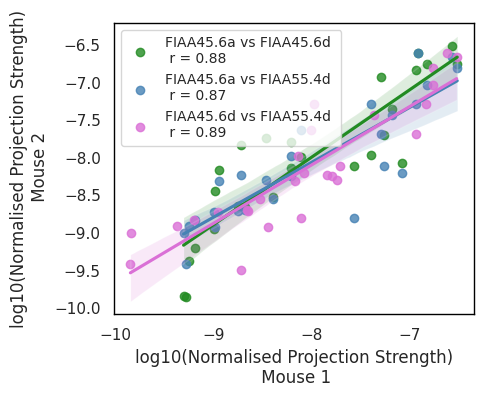

In [48]:
fig, axes = plt.subplots(1, figsize=(5, 4))
analysis_list = ['homog_across_cubelet']
corr_dict={}
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()
color_list = ['forestgreen', 'steelblue', 'orchid']
for i, key in enumerate(analysis_list):
    #correlation_matrix = pd.DataFrame(columns=mice, index=mice)
    ax = axes
    for mouse_1, mouse_2 in itertools.combinations(mice, 2):
        common_columns = set(combined_mice_dict[mouse_1][key].columns).intersection(combined_mice_dict[mouse_2][key].columns)
        common_cols_cortex = []
        for col in common_columns:
            if col != 'Contra':
                structure = structure_tree.get_structures_by_acronym([col])
                if 315 in structure[0]['structure_id_path']:
                    common_cols_cortex.append(col)
            if col == 'Contra':
                common_cols_cortex.append(col)
        mean_A = np.log10(combined_mice_dict[mouse_1][key][common_cols_cortex].mean(axis=0)+1e-10)
        mean_B = np.log10(combined_mice_dict[mouse_2][key][common_cols_cortex].mean(axis=0)+1e-10)
        corr, p = pearsonr(mean_A, mean_B)
        #sb.scatterplot(x=mean_A, y=mean_B, ax=ax, s=20, color='#3498DB', label='Data points')
        sb.regplot(x=mean_A, y=mean_B, ax=ax, scatter=True, label=f'{mouse_1} vs {mouse_2} \n r = {np.round(corr, 2)}', scatter_kws={'color':color_list[i]}, line_kws={'color':color_list[i]})
        i=i+1
    ax.set_xlabel('log10(Normalised Projection Strength)\n Mouse 1', size=12)
    ax.set_ylabel('log10(Normalised Projection Strength)\n Mouse 2', size=12)

    # Add a legend
    ax.legend(loc='upper left', fontsize=10)
    # Add a black border around the plot for visibility
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

# Adjust layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.9, wspace=0.3)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'FIAA45.6d log10(mean projection strength)')

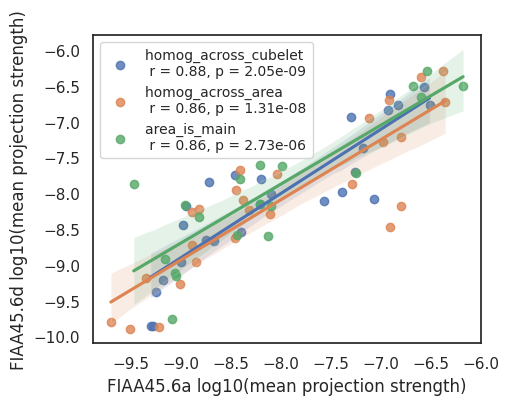

In [28]:
sb.set(font_scale=1, style='white')
#sb.set_palette(['#3498DB', '#21618C', '#A9CCE3'])
analysis_list = ['homog_across_cubelet', 'homog_across_area', 'area_is_main']
plt.figure(figsize=(5, 4))
for key in analysis_list:
    common_columns = set(combined_mice_dict['FIAA45.6a'][key].columns).intersection(combined_mice_dict['FIAA45.6d'][key].columns)
    common_cols_cortex = []
    for col in common_columns:
        if col != 'Contra':
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
        if col == 'Contra':
            common_cols_cortex.append(col)
    
    mean_FIAA456a = np.log10(combined_mice_dict['FIAA45.6a'][key][common_cols_cortex].mean(axis=0)+1e-10)
    mean_FIAA456d = np.log10(combined_mice_dict['FIAA45.6d'][key][common_cols_cortex].mean(axis=0)+1e-10)
    corr, p = pearsonr(mean_FIAA456a, mean_FIAA456d)
    sb.regplot(x=mean_FIAA456a, y=mean_FIAA456d, label=f'{key} \n r = {corr:.2g}, p = {p:.2e}')
    
plt.legend(fontsize='small')
plt.xlabel('FIAA45.6a log10(mean projection strength)')
plt.ylabel('FIAA45.6d log10(mean projection strength)')
# corr, p = pearsonr(
#     to_plot["Allen_Z_core"], y=to_plot["MAPseq_Z_score"]
# )
# corr, p = pearsonr(to_plot["Allen_Z_core"], to_plot["MAPseq_Z_score"])
# # plt.title(
# #     f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}"
# # )
# plt.xlabel('Mean Total Projection Strength \n (Anterograde Tracing Z score)', size=14)
# plt.ylabel('Individual Total Projection Strength \n (MAPseq/Anterograde Z score)', size=14)
# plt.legend(loc='lower right', fontsize='small')
# plt.text(0.02, 0.98, f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')


Text(0, 0.5, 'FIAA45.6d log10(mean projection strength)')

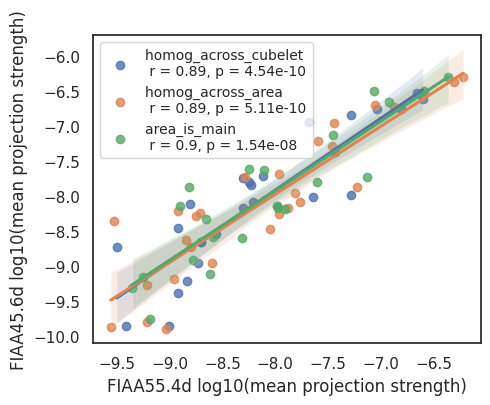

In [100]:
sb.set(font_scale=1, style='white')
#sb.set_palette(['#3498DB', '#21618C', '#A9CCE3'])
analysis_list = ['homog_across_cubelet', 'homog_across_area', 'area_is_main']
plt.figure(figsize=(5, 4))
for key in analysis_list:
    common_columns = set(combined_mice_dict['FIAA55.4d'][key].columns).intersection(combined_mice_dict['FIAA45.6d'][key].columns)
    common_cols_cortex = []
    for col in common_columns:
        if col != 'Contra':
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
        if col == 'Contra':
            common_cols_cortex.append(col)
    mean_FIAA554d = np.log10(combined_mice_dict['FIAA55.4d'][key][common_cols_cortex].mean(axis=0)+1e-10)
    mean_FIAA456d = np.log10(combined_mice_dict['FIAA45.6d'][key][common_cols_cortex].mean(axis=0)+1e-10)
    corr, p = pearsonr(mean_FIAA554d, mean_FIAA456d)
    sb.regplot(x=mean_FIAA554d, y=mean_FIAA456d, label=f'{key} \n r = {corr:.2g}, p = {p:.2e}')
    
plt.legend(fontsize='small')
plt.xlabel('FIAA55.4d log10(mean projection strength)')
plt.ylabel('FIAA45.6d log10(mean projection strength)')
# corr, p = pearsonr(
#     to_plot["Allen_Z_core"], y=to_plot["MAPseq_Z_score"]
# )
# corr, p = pearsonr(to_plot["Allen_Z_core"], to_plot["MAPseq_Z_score"])
# # plt.title(
# #     f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}"
# # )
# plt.xlabel('Mean Total Projection Strength \n (Anterograde Tracing Z score)', size=14)
# plt.ylabel('Individual Total Projection Strength \n (MAPseq/Anterograde Z score)', size=14)
# plt.legend(loc='lower right', fontsize='small')
# plt.text(0.02, 0.98, f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')


Plot correlation to bulk tracing

In [29]:
mcc = MouseConnectivityCache()
#     download_allen = pathlib.Path(
#     "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/Allen_Connectivity"
# )

#these expts have already been downloaded. If not you'll have to re-download
finalpix_expt_a = pd.read_pickle("mouse_connectivity/finalpix_expt_a.pkl")
finalpix_expt_b = pd.read_pickle("mouse_connectivity/finalpix_expt_b.pkl")
finalpix_expt_c = pd.read_pickle("mouse_connectivity/finalpix_expt_c.pkl")
# allen anterograde tracing datasets with more than 75% injection site AUDp
experiment_id_a = 120491896  # AUDp
experiment_id_b = 116903230  # AUDp, AUDpo, AUDd, AUDv
experiment_id_c = 100149109  # AUDp and AUDd
# injection volumes to normalise to (mm3)
expt_a_inj_vol = 0.097
expt_b_inj_vol = 0.114
expt_c_inj_vol = 0.073
# get projection density for each anterograde tracing expt: values are sum of projecting pixels per voxel.
expt_a, pd_a_info = mcc.get_projection_density(experiment_id_a)
expt_b, pd_b_info = mcc.get_projection_density(experiment_id_b)
expt_c, pd_c_info = mcc.get_projection_density(experiment_id_c)
# create an average of three experiments normalised by injection volume
expt_a_normalised = expt_a / expt_a_inj_vol
expt_b_normalised = expt_b / expt_b_inj_vol
expt_c_normalised = expt_c / expt_c_inj_vol

In [30]:
#let's plot mean projection density across the visual cortex
vis_regions = ['VISp', 'VISpor', 'VISrl', 'VISl', 'VISli', 'VISpl', 'VISa', 'VISal', 'VISam', 'VISpm']
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()
expts = [expt_a, expt_b, expt_c]
mean_vis_df = pd.DataFrame(columns = vis_regions, index=[0, 1, 2])
shape_template = (528, 320, 456)
x_midpoint = shape_template[2] // 2
contra_mask = np.zeros(shape_template, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1
expt_dict = {}
for i, experiment in enumerate(expts):
    expt_dict[i] = experiment*contra_mask
for acronym in vis_regions:
    structure = structure_tree.get_structures_by_acronym([acronym])
    structure_id = structure[0]['id']
    mask = rsp.make_structure_mask([structure_id], direct_only=False)
    for i, expt_loaded in enumerate(expt_dict.keys()):
        projection_density_to_look = expt_dict[expt_loaded][np.where(mask==1)]
        mean_projection_density = np.mean(projection_density_to_look)
        sum_proj_density = np.sum(projection_density_to_look)
        mean_vis_df.loc[i, acronym] = mean_projection_density
        
        

In [31]:
logged_vis = np.log10(mean_vis_df.astype(float))
df_z_normalized = (logged_vis.T - logged_vis.mean(axis=1)) / logged_vis.std(axis=1)
df_z_normalized = df_z_normalized.T

Text(0.02, 0.98, 'r = 0.728, p = 1.70E-2')

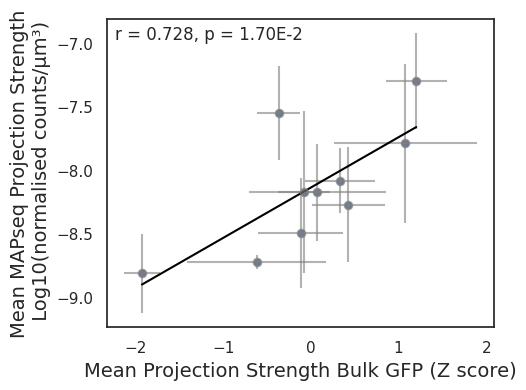

In [32]:
#combined_df = pd.concat([combined_mice_dict['FIAA45.6d']['homog_across_cubelet'][vis_regions], combined_mice_dict['FIAA45.6a']['homog_across_cubelet'][vis_regions]])
mean_MAPseq = pd.DataFrame()
mean_MAPseq = pd.concat([combined_mice_dict['FIAA45.6d']['homog_across_cubelet'][vis_regions].mean(), combined_mice_dict['FIAA45.6a']['homog_across_cubelet'][vis_regions].mean(), combined_mice_dict['FIAA55.4d']['homog_across_cubelet'][vis_regions].mean()], axis=1, ignore_index=True)
logged_MAPseq = np.log10(mean_MAPseq.T)

plt.figure(figsize=(5, 4))
sb.scatterplot(x=df_z_normalized.mean(), y=logged_MAPseq.mean())


plt.errorbar(x=df_z_normalized.mean(), y=logged_MAPseq.mean(), xerr=df_z_normalized.std(), yerr=logged_MAPseq.std(), fmt='o', color='gray', alpha=0.6, label='Error Bars')
#sb.regplot(x=df_z_normalized.mean(), y=logged_MAPseq.mean(), scatter=False)

slope, intercept = np.polyfit(df_z_normalized.mean(), logged_MAPseq.mean(), 1)  # 1 for a linear fit

# Generate points along the best-fit line for plotting
x_fit = np.linspace(min(df_z_normalized.mean()), max(df_z_normalized.mean()), 100)
y_fit = slope * x_fit + intercept

# Plot the best-fit line
plt.plot(x_fit, y_fit, color='black', label='Best Fit Line')
# corr, p = pearsonr(
#     to_plot["Allen_Z_core"], y=to_plot["MAPseq_Z_score"]
# )
corr, p = pearsonr(df_z_normalized.mean(), logged_MAPseq.mean())
# plt.title(
#     f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}"
# )
plt.xlabel('Mean Projection Strength Bulk GFP (Z score)', size=14)
plt.ylabel('Mean MAPseq Projection Strength\n Log10(normalised counts/µm³)', size=14)

plt.text(0.02, 0.98, f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

Now let's plot all the cortical areas

In [33]:
key = 'homog_across_cubelet'
common_columns = set(combined_mice_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_mice_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_mice_dict['FIAA55.4d'][key].columns)
)

all_area = [area for area in common_columns]
mean_all_areas_df = pd.DataFrame(columns = all_area, index=[0, 1, 2])
columns_to_keep = []
for acronym in all_area:
    try:
        structure = structure_tree.get_structures_by_acronym([acronym])
    except KeyError:
        print(f'{acronym} does not exist - need to check naming')
        continue
    if 315 in structure[0]['structure_id_path']:
        structure_id = structure[0]['id']
        mask = rsp.make_structure_mask([structure_id], direct_only=False)
        for i, expt_loaded in enumerate(expt_dict.keys()):
            projection_density_to_look = expt_dict[expt_loaded][np.where(mask==1)]
            mean_projection_density = np.mean(projection_density_to_look)
            mean_all_areas_df.loc[i, acronym] = mean_projection_density
        columns_to_keep.append(acronym)
mean_all_areas_df = mean_all_areas_df[columns_to_keep]

combined_df = pd.concat([combined_mice_dict['FIAA45.6d'][key][columns_to_keep], combined_mice_dict['FIAA45.6a'][key][columns_to_keep]])

Contra does not exist - need to check naming


In [34]:
logged_all_cortical = np.log10(mean_all_areas_df.astype(float))
allen_z_normalized = (logged_all_cortical.T - logged_all_cortical.mean(axis=1)) / logged_all_cortical.std(axis=1)
allen_z_normalized = allen_z_normalized.T

In [35]:
mean_all_MAPseq = pd.DataFrame()
mean_all_MAPseq = pd.concat([combined_mice_dict['FIAA45.6d']['homog_across_cubelet'][columns_to_keep].mean(), combined_mice_dict['FIAA45.6a']['homog_across_cubelet'][columns_to_keep].mean(), combined_mice_dict['FIAA55.4d']['homog_across_cubelet'][columns_to_keep].mean()], axis=1, ignore_index=True)
logged_all_MAPseq = np.log10(mean_all_MAPseq.T)

In [36]:
colors = ['VIS' if column in vis_regions else 'NON-VIS' for column in logged_all_MAPseq.columns]

Text(0.02, 0.98, 'r = 0.89, p = 2.65E-9')

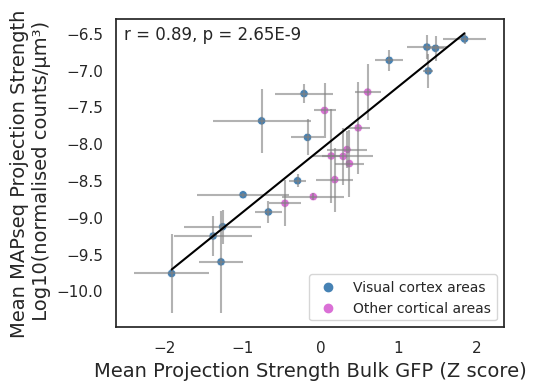

In [37]:

colors = ['VIS' if column in vis_regions else 'NON-VIS' for column in mean_all_areas_df.columns]
plt.figure(figsize=(5, 4))



plt.errorbar(x=allen_z_normalized.mean(), y=logged_all_MAPseq.mean(), xerr=allen_z_normalized.std(), yerr=logged_all_MAPseq.std(), fmt='none', color='gray', alpha=0.6, label='Error Bars')
#sb.regplot(x=allen_z_normalized.mean(), y=logged_all_MAPseq.mean(), scatter=False)
scatter = sb.scatterplot(x=allen_z_normalized.mean(), y=logged_all_MAPseq.mean(), hue=colors, palette={'VIS': 'orchid', 'NON-VIS': 'steelblue'}, alpha=1)
slope, intercept = np.polyfit(allen_z_normalized.mean(), logged_all_MAPseq.mean(), 1)  # 1 for a linear fit

# Generate points along the best-fit line for plotting
x_fit = np.linspace(min(allen_z_normalized.mean()), max(allen_z_normalized.mean()), 100)
y_fit = slope * x_fit + intercept

# Plot the best-fit line
plt.plot(x_fit, y_fit, color='black', label='Best Fit Line')
# corr, p = pearsonr(
#     to_plot["Allen_Z_core"], y=to_plot["MAPseq_Z_score"]
# )
corr, p = pearsonr(allen_z_normalized.mean(), logged_all_MAPseq.mean())
# plt.title(
#     f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}"
# )
plt.xlabel('Mean Projection Strength Bulk GFP (Z score)', size=14)
plt.ylabel('Mean MAPseq Projection Strength\n Log10(normalised counts/µm³)', size=14)
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=[handles[1], handles[2]], labels=['Visual cortex areas', 'Other cortical areas'], loc='lower right', fontsize=10)
plt.text(0.02, 0.98, f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

Contra does not exist - need to check naming
Contra does not exist - need to check naming
Contra does not exist - need to check naming


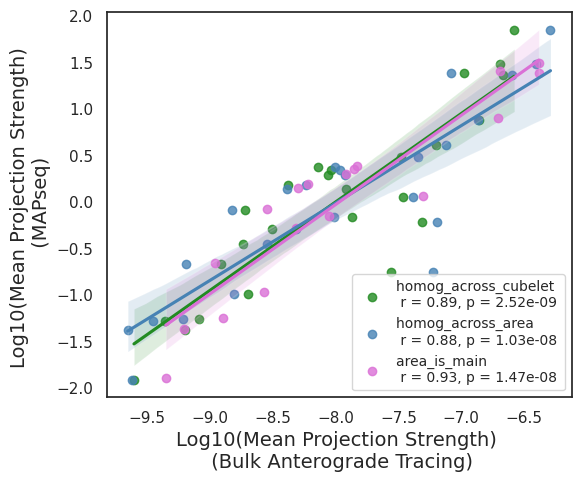

In [43]:

sb.set(font_scale=1, style='white')
#sb.set_palette(['#3498DB', '#21618C', '#A9CCE3'])
analysis_list = ['homog_across_cubelet', 'homog_across_area', 'area_is_main']
color_list = ['forestgreen', 'steelblue', 'orchid']
plt.figure(figsize=(6, 5))
for key, which_color in zip(analysis_list, color_list):
    # common_columns = set(combined_mice_dict['FIAA55.4d'][key].columns).intersection(combined_mice_dict['FIAA45.6d'][key].columns)
    # common_columns = [col for col in common_columns if col in mean_all_areas_df.columns]
    
    common_columns = set(combined_mice_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_mice_dict['FIAA45.6d'][key].columns)
    ).intersection(
        set(combined_mice_dict['FIAA55.4d'][key].columns)
    )

    all_area = [area for area in common_columns]
    mean_all_areas_df = pd.DataFrame(columns = all_area, index=[0, 1, 2])
    columns_to_keep = []
    for acronym in all_area:
        try:
            structure = structure_tree.get_structures_by_acronym([acronym])
        except KeyError:
            print(f'{acronym} does not exist - need to check naming')
            continue
        if 315 in structure[0]['structure_id_path']:
            structure_id = structure[0]['id']
            mask = rsp.make_structure_mask([structure_id], direct_only=False)
            for i, expt_loaded in enumerate(expt_dict.keys()):
                projection_density_to_look = expt_dict[expt_loaded][np.where(mask==1)]
                mean_projection_density = np.mean(projection_density_to_look)
                mean_all_areas_df.loc[i, acronym] = mean_projection_density
            columns_to_keep.append(acronym)
    mean_all_areas_df = mean_all_areas_df[columns_to_keep]
    logged_all_cortical = np.log10(mean_all_areas_df.astype(float))
    allen_z_normalized = (logged_all_cortical.T - logged_all_cortical.mean(axis=1)) / logged_all_cortical.std(axis=1)
    allen_z_normalized = allen_z_normalized.T
    combined_df = pd.concat([combined_mice_dict['FIAA45.6d'][key][columns_to_keep], combined_mice_dict['FIAA45.6a'][key][columns_to_keep]])
    mean_all_MAPseq = pd.DataFrame()
    mean_all_MAPseq = pd.concat([combined_mice_dict['FIAA45.6d'][key][columns_to_keep].mean(), combined_mice_dict['FIAA45.6a'][key][columns_to_keep].mean(), combined_mice_dict['FIAA55.4d'][key][columns_to_keep].mean()], axis=1, ignore_index=True)
    all_MAPseq = mean_all_MAPseq.T
     
        
    # allen_mean = np.log10(mean_all_areas_df[common_columns].mean())    

    # allen_mean = np.log10(mean_all_areas_df[adjusted_col].mean()) 
    # mapseq_df = np.log10(combined_df.mean())
    corr, p = pearsonr(np.log10(all_MAPseq.mean()), allen_z_normalized.mean())
    sb.regplot(x=np.log10(all_MAPseq.mean()), y=allen_z_normalized.mean(), scatter_kws={'color':which_color}, line_kws={'color':which_color}, label=f'{key} \n r = {corr:.2g}, p = {p:.2e}')
    



plt.xlabel('Log10(Mean Projection Strength) \n (Bulk Anterograde Tracing)', size=14)
plt.ylabel('Log10(Mean Projection Strength) \n (MAPseq)', size=14)


plt.legend(loc='lower right', fontsize=10)

In [28]:
logged_all_MAPseq

,VISli,AUDv,RSPagl,VISpm,AUDp,VISC,SSs,AUDd,VISrl,VISpl,...,VISp,AUDpo,ECT,ACAv,PERI,VISal,MOp,MOs,RSPd,TEa
0,-7.482919,-6.700192,-8.311141,-8.254397,-6.243435,-inf,-8.039029,-7.231476,-8.068332,-8.334507,...,-8.765886,-6.275933,-7.214024,-10.334841,-8.050708,-6.961816,-10.355923,-9.486318,-8.998092,-6.669312
1,-6.963268,-6.345583,-8.107638,-9.297733,-6.298296,-7.197318,-8.469268,-6.778906,-8.451666,-8.771782,...,-8.921936,-6.638426,-7.027160,-8.439981,-6.810421,-7.238084,-9.129400,-10.246827,-9.954294,-6.951476
2,-8.470527,-6.864211,-8.976901,-8.106255,-6.076059,-inf,-8.014912,-7.489558,-8.051473,-9.171126,...,-8.590977,-6.389013,-7.502332,-10.202608,-7.994900,-8.545459,-9.475114,-9.464281,-8.650353,-7.170907


In [25]:
FIAA55.4d

{'ACAd',
 'ACAv',
 'AUDd',
 'AUDp',
 'AUDpo',
 'AUDv',
 'Contra',
 'ECT',
 'HPF',
 'MOp',
 'MOs',
 'PERI',
 'RSPagl',
 'RSPd',
 'RSPv',
 'SSp',
 'SSs',
 'TEa',
 'VISC',
 'VISa',
 'VISal',
 'VISam',
 'VISl',
 'VISli',
 'VISp',
 'VISpl',
 'VISpm',
 'VISpor',
 'VISrl'}

No handles with labels found to put in legend.


Text(0.02, 0.98, 'r = 0.745, p = 1.34E-2')

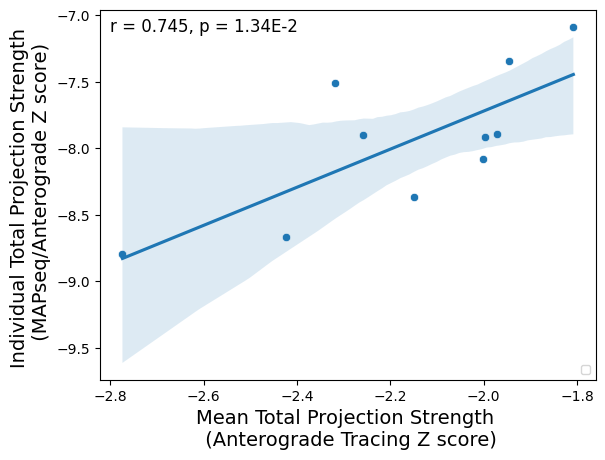

In [20]:
combined_df = pd.concat([combined_mice_dict['FIAA45.6d']['homog_across_cubelet'][vis_regions], combined_mice_dict['FIAA45.6a']['homog_across_cubelet'][vis_regions], combined_mice_dict['FIAA55.4d']['homog_across_cubelet'][vis_regions]])

sb.scatterplot(x=np.log10(mean_vis_df.mean()), y=np.log10(combined_df.mean()))
sb.regplot(x=np.log10(mean_vis_df.mean()), y=np.log10(combined_df.mean()), scatter=False)
# corr, p = pearsonr(
#     to_plot["Allen_Z_core"], y=to_plot["MAPseq_Z_score"]
# )
corr, p = pearsonr(np.log10(mean_vis_df.mean()), np.log10(combined_df.mean()))
# plt.title(
#     f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}"
# )
plt.xlabel('Mean Total Projection Strength \n (Anterograde Tracing Z score)', size=14)
plt.ylabel('Individual Total Projection Strength \n (MAPseq/Anterograde Z score)', size=14)
plt.legend(loc='lower right', fontsize='small')
plt.text(0.02, 0.98, f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

In [96]:
key = 'homog_across_cubelet'
common_columns =  set(combined_mice_dict['FIAA45.6a'][key].columns).intersection(combined_mice_dict['FIAA45.6d'][key].columns)

all_area = [area for area in common_columns]
mean_all_areas_df = pd.DataFrame(columns = all_area, index=[0, 1, 2])
columns_to_keep = []
for acronym in all_area:
    try:
        structure = structure_tree.get_structures_by_acronym([acronym])
    except KeyError:
        print(f'{acronym} does not exist - need to check naming')
    if 315 in structure[0]['structure_id_path']:
        structure_id = structure[0]['id']
        mask = rsp.make_structure_mask([structure_id], direct_only=False)
        for i, expt_loaded in enumerate(expt_dict.keys()):
            projection_density_to_look = expt_dict[expt_loaded][np.where(mask==1)]
            mean_projection_density = np.mean(projection_density_to_look)
            mean_all_areas_df.loc[i, acronym] = mean_projection_density
        columns_to_keep.append(acronym)
mean_all_areas_df = mean_all_areas_df[columns_to_keep]
combined_df = pd.concat([combined_mice_dict['FIAA45.6d'][key][columns_to_keep], combined_mice_dict['FIAA45.6a'][key][columns_to_keep]])

Contra does not exist - need to check naming


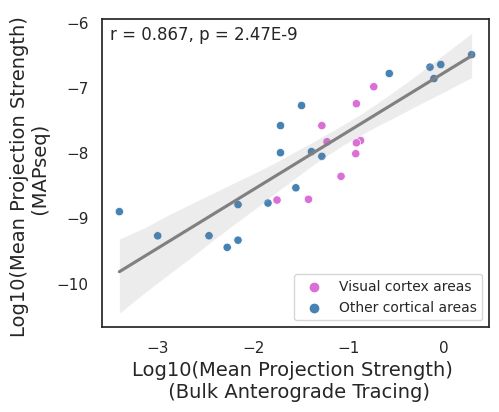

In [40]:
mapseq_df = combined_df[mean_all_areas_df.columns]
colors = ['VIS' if column in vis_regions else 'NON-VIS' for column in mean_all_areas_df.columns]
plt.figure(figsize=(5, 4))
scatter = sb.scatterplot(x=np.log10(mean_all_areas_df.mean()), y=np.log10(mapseq_df.mean()), hue=colors, palette={'VIS': 'orchid', 'NON-VIS': 'steelblue'})
sb.regplot(x=np.log10(mean_all_areas_df.mean()), y=np.log10(mapseq_df.mean()), scatter=False, color='gray')
# corr, p = pearsonr(
#     to_plot["Allen_Z_core"], y=to_plot["MAPseq_Z_score"]
# )
corr, p = pearsonr(np.log10(mean_all_areas_df.mean()), np.log10(mapseq_df.mean()))
# plt.title(
#     f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}"
# )

plt.xlabel('Log10(Mean Projection Strength) \n (Bulk Anterograde Tracing)', size=14)
plt.ylabel('Log10(Mean Projection Strength) \n (MAPseq)', size=14)
plt.text(0.02, 0.98, f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=[handles[0], handles[1]], labels=['Visual cortex areas', 'Other cortical areas'], loc='lower right', fontsize=10)


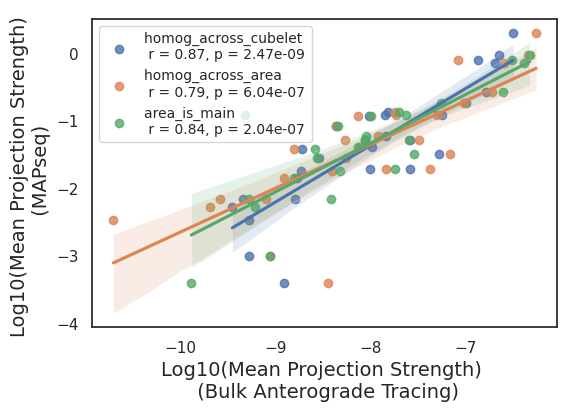

In [53]:
sb.set(font_scale=1, style='white')
#sb.set_palette(['#3498DB', '#21618C', '#A9CCE3'])
analysis_list = ['homog_across_cubelet', 'homog_across_area', 'area_is_main']
plt.figure(figsize=(6, 4))
for key in analysis_list:
    common_columns = set(combined_mice_dict['FIAA55.4d'][key].columns).intersection(combined_mice_dict['FIAA45.6d'][key].columns)
    common_columns = [col for col in common_columns if col in mean_all_areas_df.columns]
    allen_mean = np.log10(mean_all_areas_df[common_columns].mean())    
    combined_df = pd.concat([combined_mice_dict['FIAA45.6d'][key][common_columns], combined_mice_dict['FIAA45.6a'][key][common_columns]])
    combined_df = combined_df.loc[:, (combined_df != 0).any(axis=0)] #remove columns where all zeros (need to adjust in main functions)
    adjusted_col = [col for col in common_columns if col in combined_df.columns]
    allen_mean = np.log10(mean_all_areas_df[adjusted_col].mean()) 
    mapseq_df = np.log10(combined_df.mean())
    corr, p = pearsonr(mapseq_df, allen_mean)
    sb.regplot(x=mapseq_df, y=allen_mean, label=f'{key} \n r = {corr:.2g}, p = {p:.2e}')
    



plt.xlabel('Log10(Mean Projection Strength) \n (Bulk Anterograde Tracing)', size=14)
plt.ylabel('Log10(Mean Projection Strength) \n (MAPseq)', size=14)


plt.legend(loc='upper left', fontsize=10)


Make venn diagram of shared barcodes

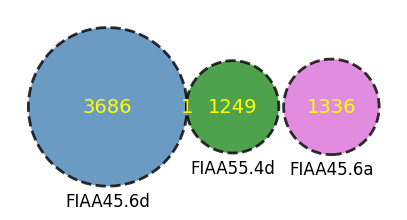

In [107]:
from matplotlib_venn import venn3
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
dfs = {}
for i, mouse in enumerate(mice):
    parameters_path = str(proj_path) +'/' + mouse + '/Sequencing'
    # Load the barcode data for the current mouse
    if mouse == 'FIAA55.4d':
        barcodes = pd.read_pickle(f'{parameters_path}/A1_barcodes_thresholded.pkl')
    else:
        barcodes = pd.read_pickle(f'{parameters_path}/A1_barcodes_thresholded_new.pkl')
    indices = set(barcodes.index)
    dfs[i] = indices


# Create a Venn diagram
plt.figure(figsize=(5, 3))
venn = venn3([dfs[0], dfs[1], dfs[2]], (f'{mice[0]}', f'{mice[1]}', f'{mice[2]}'))

colors = ['orchid', 'steelblue', 'forestgreen']  # Set your desired colors here

alpha_value = 0.8  # Set alpha to make colors less see-through

# Apply colors and reduce transparency
venn.get_patch_by_id('100').set_facecolor(colors[0])
venn.get_patch_by_id('100').set_alpha(alpha_value)
venn.get_patch_by_id('010').set_facecolor(colors[1])
venn.get_patch_by_id('010').set_alpha(alpha_value)
venn.get_patch_by_id('001').set_facecolor(colors[2])
venn.get_patch_by_id('001').set_alpha(alpha_value)


# Set black borders for all patches
for patch in venn.patches:
    if patch is not None:
        patch.set_edgecolor('black')
        patch.set_linewidth(2),
        patch.set_linestyle('--')
for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(14)  # Set font size
        label.set_color('yellow') 



plt.show()


In [67]:
from scipy.stats import zscore
normalized_areas = zscore(mean_all_areas_df)
x = np.log(normalized_areas.mean())
y = np.log(mapseq_df.mean())

# Calculate standard error for error bars
xerr = np.log(mean_all_areas_df.std() / np.sqrt(mean_all_areas_df.count()))
yerr = np.log(mapseq_df.std() / np.sqrt(mapseq_df.count()))


# Create scatter plot with error bars
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ecolor='gray', elinewidth=1, capsize=3)

plt.xlabel('Log10 Mean of all Areas')
plt.ylabel('Log10 Mean of MapSeq')

plt.show()

TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable sqrt method

In [63]:
xerr

VISp     -4.814970
VISpor   -4.426069
VISrl    -2.750956
VISl     -4.806167
VISli    -3.415209
VISpl    -6.407705
VISa     -2.473113
VISal    -2.240609
VISam    -2.102188
VISpm    -2.995893
AUDp     -0.744972
ACAd     -7.042363
VISC     -5.020417
AUDd     -1.380906
SSp      -4.917653
RSPv     -8.057788
RSPd     -5.935859
Contra   -5.935859
TEa      -3.713608
MOs      -5.196603
RSPagl   -4.200340
ACAv     -7.791456
ECT      -4.417298
AUDv     -2.680673
PERI     -4.294850
AUDpo    -1.103669
SSs      -3.794543
MOp      -5.501468
dtype: float64

In [33]:
look_me = pd.DataFrame()
allen = np.log10(mean_all_areas_df.mean())
mapseq = np.log10(combined_df.mean())
look_me['allen'] =allen
look_me['mapseq'] =mapseq

In [34]:
look_me[(look_me['allen']<-2.5) & (look_me['mapseq']>-8.5)]

,allen,mapseq
HPF,-2.733916,-8.05661


In [75]:
def extract_tubes_and_centroids(ROI_array):
    unique_tubes = np.unique(ROI_array)
    # Filter out the tubes with label 0 and compute centroids
    tubes = unique_tubes[unique_tubes > 0]
    centroids = [np.argwhere(ROI_array == tube).mean(axis=0) for tube in tubes]
    return pd.DataFrame({"Tube": tubes, "Centroid": centroids})

ROI_coords={}
for mouse in mice:
    ROI_coords[mouse] =extract_tubes_and_centroids(ROI_mouse[mouse])
    

# Compute all combinations of centroids between the two ROIs
combinations = np.array(np.meshgrid(ROI_coords['FIAA45.6d']["Centroid"], ROI_coords['FIAA45.6a']["Centroid"])).T.reshape(-1, 2)
tube_comp = np.array(np.meshgrid(ROI_coords['FIAA45.6d']["Tube"], ROI_coords['FIAA45.6a']["Tube"])).T.reshape(-1, 2)

# Calculate distances between all centroid combinations
distances = np.linalg.norm(np.stack(combinations[:, 0]) - np.stack(combinations[:, 1]), axis=1)

# Create a DataFrame with the distances and tube pairings
distances_rois = pd.DataFrame({
    "Tube A": tube_comp[:, 0],
    "Tube B": tube_comp[:, 1],
    "Distance": distances
})

# Find minimum distance for each Tube A and Tube B
df_min_distance = pd.concat([
    distances_rois.loc[distances_rois.groupby("Tube A")["Distance"].idxmin()],
    distances_rois.loc[distances_rois.groupby("Tube B")["Distance"].idxmin()]
]).drop_duplicates()


df_min_distance["FIAA45.6a"] = np.nan  # Initialize the column with NaN
df_min_distance["FIAA45.6d"] = np.nan 

for i, r in df_min_distance.iterrows():
    # Assign values to the 'FIAA45.6a' column
    df_min_distance.at[i, 'FIAA45.6a'] = np.log10(
        (mouse_barcodes['FIAA45.6d'][r["Tube A"]].sum()/np.sum(ROI_mouse['FIAA45.6a']==r["Tube A"])) + 1e-3
    )
    
    # Assign values to the 'FIAA45.6d' column
    df_min_distance.at[i, "FIAA45.6d"] = np.log10(
       (mouse_barcodes['FIAA45.6d'][r["Tube B"]].sum()/np.sum(ROI_mouse['FIAA45.6a']==r["Tube B"])) + 1e-3
    )
df_min_distance.fillna(0, inplace=True)


KeyboardInterrupt: 

In [77]:
mouse_barcodes['FIAA45.6d'][r["Tube A"]].sum()/1

0.0

In [78]:
np.sum(ROI_mouse['FIAA45.6a']==r["Tube A"])

190.0

ValueError: array must not contain infs or NaNs

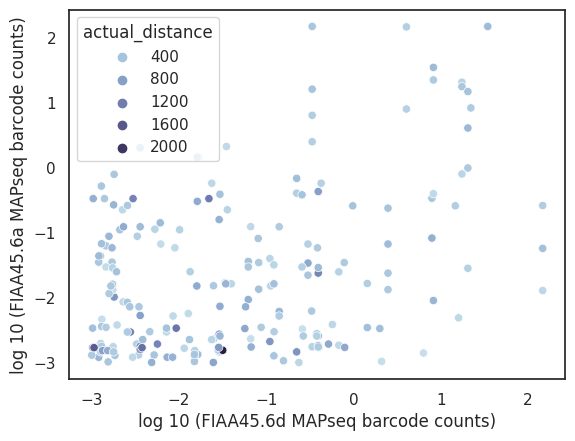

In [68]:
df_min_distance['actual_distance'] = df_min_distance['Distance']*25
sb.scatterplot(
    data=df_min_distance,
    x="FIAA45.6d",
    y="FIAA45.6a", hue= 'actual_distance',
    palette="ch:s=.25,rot=-.25",
)
sb.regplot(data=df_min_distance, x="FIAA45.6d", y="FIAA45.6a", scatter=False)
plt.xlabel("log 10 (FIAA45.6d MAPseq barcode counts)")
plt.ylabel("log 10 (FIAA45.6a MAPseq barcode counts)")

corr, p = pearsonr(
    df_min_distance["FIAA45.6d"], y=df_min_distance["FIAA45.6a"]
)
plt.title(
    f"FIAA45.6a versus FIAA45.6d counts in equivalent samples \n (r = {np.round(corr, 3)}, p = {Decimal(p):.2E})"
)

In [42]:
df_min_distance["FIAA45.6a"] = np.nan  # Initialize the column with NaN
df_min_distance["FIAA45.6d"] = np.nan 

In [43]:
df_min_distance= pd.DataFrame(columns=mice)
for i, r in df_min_distance.iterrows():
    # Assign values to the 'FIAA45.6a' column
    df_min_distance.at[i, 'FIAA45.6a'] = np.log10(
        mouse_barcodes['FIAA45.6d'][r["Tube A"]].sum() + 1e-3
    )
    
    # Assign values to the 'FIAA45.6d' column
    df_min_distance.at[i, "FIAA45.6d"] = np.log10(
        mouse_barcodes['FIAA45.6d'][r["Tube_B"]].sum() + 1e-3
    )

In [44]:
df_min_distance

,FIAA45.6a,FIAA45.6d


In [ ]:
tubes_FIAA456a = []
centroids_FIAA456a = []
for tube in np.unique(ROI_3D_FIAA456a):
    if tube > 0:
        centroid = np.argwhere(ROI_3D_FIAA456a == tube).mean(axis=0)
        tubes_FIAA456a.append(tube)
        centroids_FIAA456a.append(centroid)

ROI_coords = pd.DataFrame({"Tube": tubes_FIAA456a, "Centroid": centroids_FIAA456a})


tubes = []
centroids = []
for tube in np.unique(ROI_3D_FIAA456d):
    if tube > 0:
        centroid = np.argwhere(ROI_3D_FIAA456d == tube).mean(axis=0)
        tubes.append(tube)
        centroids.append(centroid)

ROI_coords_FIAA456d = pd.DataFrame({"Tube": tubes, "Centroid": centroids})

combinations = [
    (x, y) for x in ROI_coords_FIAA456d["Centroid"] for y in ROI_coords["Centroid"]
]
tube_comp = [(x, y) for x in ROI_coords_FIAA456d["Tube"] for y in ROI_coords["Tube"]]
distances = []
for i in combinations:
    dist = np.linalg.norm(i[0] - i[1])
    distances.append(dist)
tube_A = []
tube_B = []
for i in tube_comp:
    tube_A.append(i[0])
    tube_B.append(i[1])
distances_rois = pd.DataFrame(
    {"Tube A": tube_A, "Tube_B": tube_B, "Distance": distances}
)
df_min_distance = distances_rois.loc[
    distances_rois.groupby("Tube A")["Distance"].idxmin()
]
df_min_distance = pd.concat([df_min_distance, distances_rois.loc[
    distances_rois.groupby("Tube_B")["Distance"].idxmin()
]])
df_min_distance = df_min_distance.drop_duplicates()

In [64]:
cols = ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']
mouse = 'FIAA45.6a'
vis_projecting = combined_mice_dict[mouse]['homog_across_cubelet'][combined_mice_dict[mouse]['homog_across_cubelet'][cols].sum(axis=1)>0]

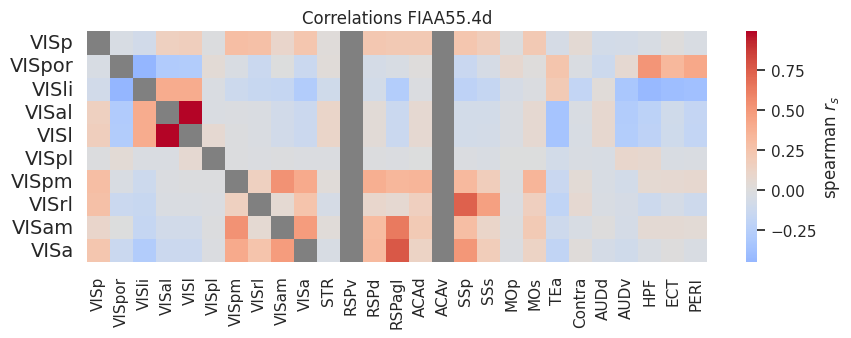

In [65]:
cols_to_comp = ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa', 'STR', 'RSPv', 'RSPd', 'RSPagl', 'ACAd', 'ACAv', 'SSp', 'SSs', 'MOp', 'MOs', 'TEa', 'Contra', 'AUDd', 'AUDv', 'HPF', 'ECT', 'PERI']
cols=['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']
correlations = vis_projecting[cols_to_comp].corr(method='spearman')
np.fill_diagonal(correlations.values, np.nan)
filtered_corr_matrix = correlations.loc[cols]
#filtered_corr_matrix = convert_matrix_names(filtered_corr_matrix)
cmap = sb.color_palette("coolwarm", as_cmap=True)
cmap.set_bad('grey')  # Set NaN values to grey
plt.figure(figsize=(10, 3)) 
sb.heatmap(filtered_corr_matrix, cmap=cmap, center=0, cbar_kws={'label': 'spearman $r_{s}$'})
plt.tick_params(axis='y', which='major', labelsize=14, rotation=0)
plt.title('Correlations FIAA55.4d')
plt.show()

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'VISp'),
  Text(0, 1.5, 'VISpor'),
  Text(0, 2.5, 'VISli'),
  Text(0, 3.5, 'VISal'),
  Text(0, 4.5, 'VISl'),
  Text(0, 5.5, 'VISpl'),
  Text(0, 6.5, 'VISpm'),
  Text(0, 7.5, 'VISrl'),
  Text(0, 8.5, 'VISam'),
  Text(0, 9.5, 'VISa')])

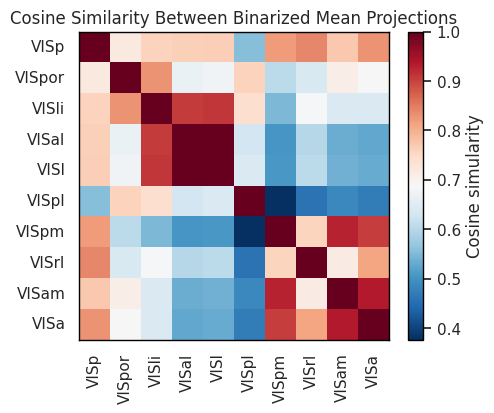

In [66]:
from sklearn.metrics.pairwise import cosine_similarity
cols = ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']
#cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
combined_matrix =vis_projecting
cosine_sim_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
pearson_corr_mat = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
mean_proj_mat = pd.DataFrame(columns = combined_matrix.columns)
numbers_mat = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)

for number, col in enumerate(cols):
    neurons_1 = combined_matrix[combined_matrix[col] >0].astype(bool).astype(int).mean(axis=0)
    new_df =pd.DataFrame(neurons_1).T
    if number == 0:
        mean_proj_mat = new_df.copy()
    else:
        mean_proj_mat = pd.concat([mean_proj_mat, new_df])

    for col_2 in cols:
        neurons_2 = combined_matrix[combined_matrix[col_2] >0].astype(bool).astype(int).mean(axis=0)
        correlation, _ =pearsonr(neurons_1, neurons_2)
        bl = np.array(neurons_1).reshape(1, -1)
        bl_2 = np.array(neurons_2).reshape(1, -1)
        cosine_sim = cosine_similarity(bl, bl_2)
        tot_proj = np.dot(bl, bl_2.T)
        cosine_sim_matrix.loc[col, col_2] = cosine_sim[0][0]
        cosine_sim_matrix.loc[col_2, col] = cosine_sim[0][0]
        pearson_corr_mat.loc[col, col_2] = correlation
        pearson_corr_mat.loc[col_2, col] = correlation
        numbers_mat.loc[col, col_2] = tot_proj
        numbers_mat.loc[col_2, col] = tot_proj
mean_proj_mat.index = cols        
        
plt.figure(figsize=(5,4))
cosine_sim_matrix_renamed = cosine_sim_matrix.copy()
#cosine_sim_matrix_renamed = convert_matrix_names(cosine_sim_matrix_renamed)

ax= sb.heatmap(cosine_sim_matrix_renamed, cmap='RdBu_r', cbar_kws={'label': 'Cosine simularity'})
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
cbar = ax.collections[0].colorbar
cbar.outline.set_visible(True)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)
plt.title('Cosine Similarity Between Binarized Mean Projections')
plt.yticks(rotation=0) 

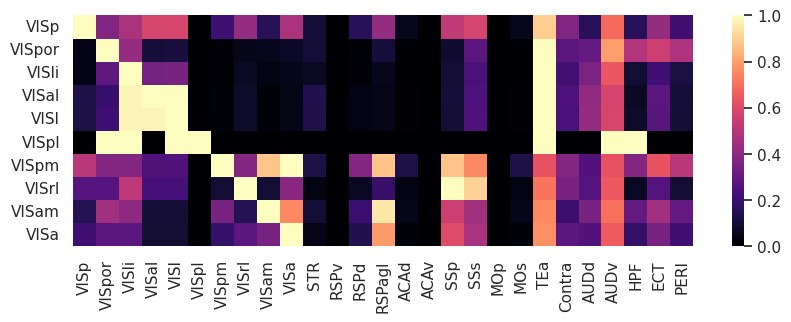

In [67]:
plt.figure(figsize=(10,3))
g = sb.heatmap(mean_proj_mat[cols_to_comp], cmap='magma')
plt.show()

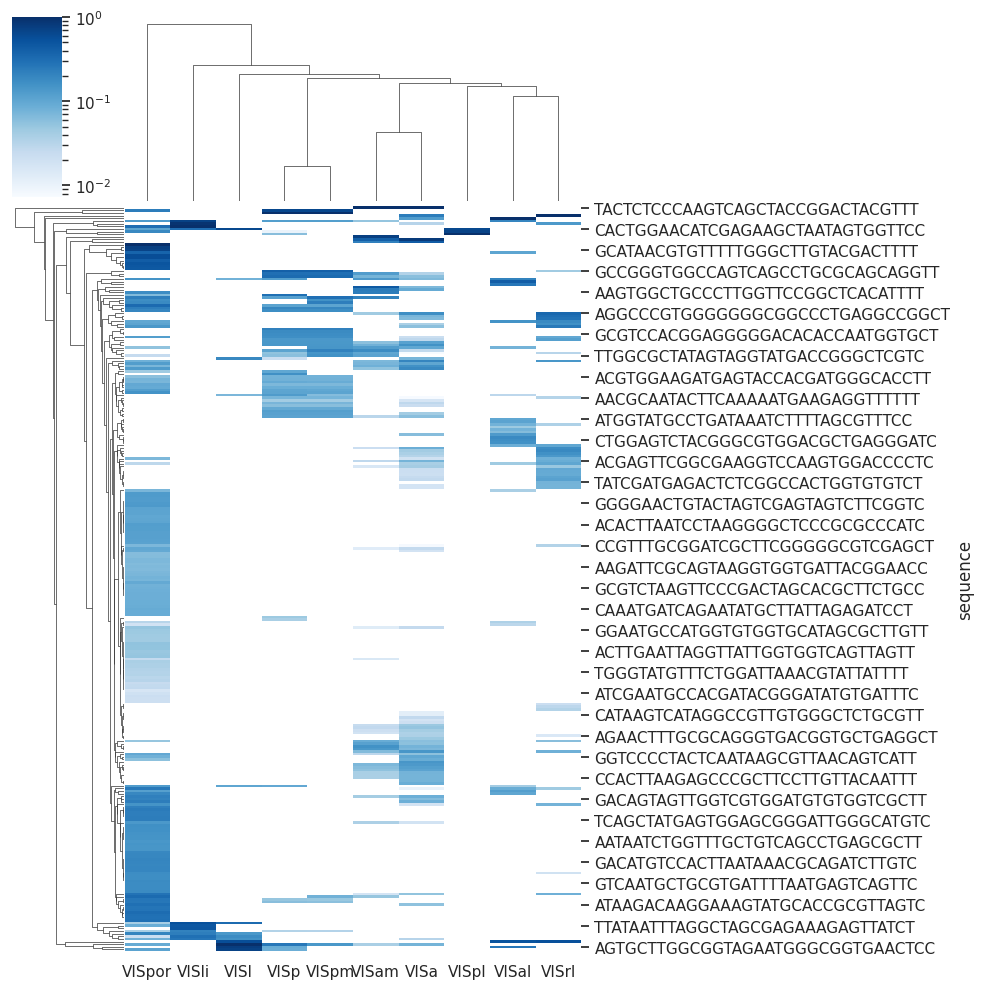

In [16]:
sb.clustermap(vis_projecting[cols], standard_scale=1, norm=LogNorm(), cmap='Blues')

In [ ]:
for mouse in mice"

In [12]:
bl=pd.DataFrame()
bl['FIAA456a'] =mean_FIAA456a
bl['FIAA456d'] =mean_FIAA456d

In [89]:


new_dict[f'{layer}_layer'][(new_dict[f'{layer}_layer'][[f for f in parameters['cortical_samples'] if f in barcodes.columns]].astype(bool).sum(axis=1)>0)]

,1,2,3,4,5,6,7,8,9,11,...,171,172,173,174,175,176,177,178,179,180
sequence,,,,,,,,,,,,,,,,,,,,,
GAGCGTGAGGCAGGTTTCGTATGGGGCGCTTC,0.0,23.521579,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
GAACGCTTAGGGGGAACTACGTTCTTGTGGTC,0.0,0.000000,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
TGTTGTGCGTTGGTGGGGCATGAAGGGTTCCC,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
TAATGTATTATCGTTTGGCACAGGTACCAGTT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.490955,0.0,0.0,0.0,0.0
CTTAATAGCAATCGGCACATGATACCTTTATT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATGCAGTCTGAGTAAAATCAAGCATCACGCT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
TGAAGGAAAACTGAGGAAAAGCTCCGTTAGCT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
GCCCCGAACTGGAGGTTATCGTCCGCGCGTTT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [88]:
barcodes.drop(columns=AUDp_containing, inplace=True)

In [85]:
barcodes[63]

sequence
GAGCGTGAGGCAGGTTTCGTATGGGGCGCTTC    21.438624
GAACGCTTAGGGGGAACTACGTTCTTGTGGTC     0.000000
GGAATTTCGTTCGCTCTCGGTAGGTGGCATTT     0.000000
TGTTGTGCGTTGGTGGGGCATGAAGGGTTCCC     0.000000
TAATGTATTATCGTTTGGCACAGGTACCAGTT     0.000000
                                      ...    
AACACACGGTCCCCAGTCGTAATTAACTCTCT     0.000000
ATTCTCGATAGGTCTAAGTTGTCGCGATACTC     0.000000
TTCCGTGCATAATTTATCGTACATCCCGGTTT     0.000000
GCGGGACGGGGAGCGGGGTGGGACACGCGTCC     0.000000
GGGTGGTTAAGATGTACAGTGATCGGGCTCCT     0.000000
Name: 63, Length: 1467, dtype: float64

In [111]:
striatum_projecting

,Striatum,Tectum,Thalamus,Contra Cortex,Ipsi Cortex
sequence,,,,,
GAGCGTGAGGCAGGTTTCGTATGGGGCGCTTC,60.856254,35.632574,11.707723,192.030259,765.447965
GAACGCTTAGGGGGAACTACGTTCTTGTGGTC,10.365919,0.000000,0.000000,12.257143,109.251992
GGAATTTCGTTCGCTCTCGGTAGGTGGCATTT,20.378148,0.000000,0.000000,7.079704,44.074483
TGTTGTGCGTTGGTGGGGCATGAAGGGTTCCC,19.417943,0.000000,0.000000,0.000000,49.153015
TAATGTATTATCGTTTGGCACAGGTACCAGTT,5.715325,0.000000,0.000000,15.885714,118.449308
...,...,...,...,...,...
TTATTGATTGGTGAAACTCGAGTATTGGAATT,54.790856,0.000000,0.000000,0.000000,0.000000
GGGCGAACGGGGCTAGGGCCATGGACTGGGCC,18.766582,0.000000,0.000000,0.000000,0.000000
TAGCTAGACATTCTACCGTTTTATCGGTATTC,11.960408,0.000000,0.000000,0.000000,0.000000


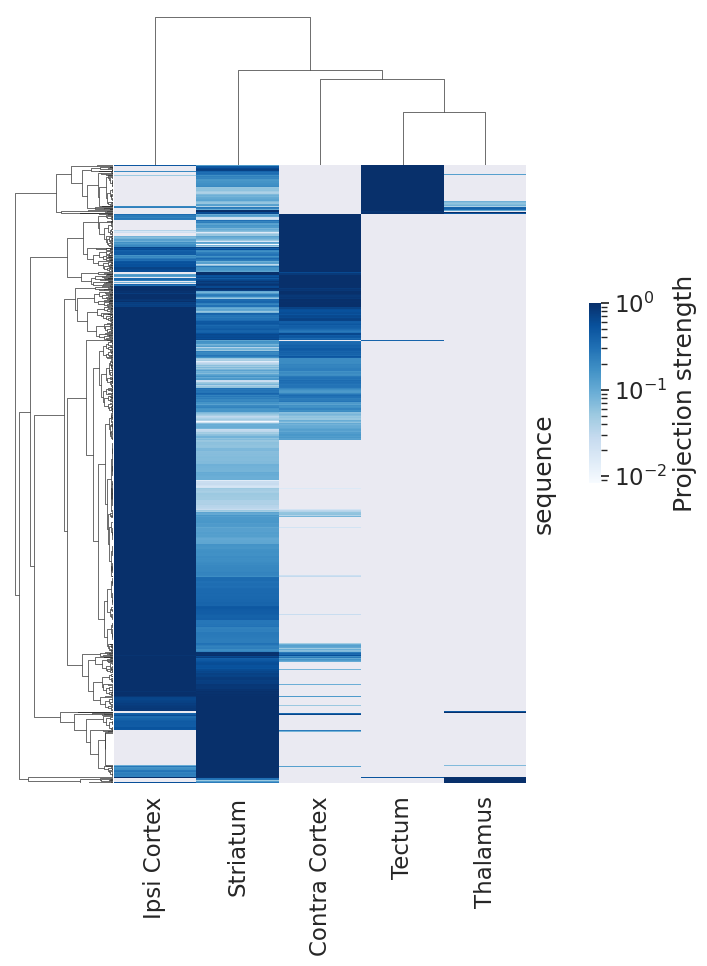

In [110]:
sb.set(font_scale=1.5)
striatum_projecting = combined_table[combined_table["Striatum"] > 0]
sb.clustermap(
    striatum_projecting,
    metric="euclidean",
    standard_scale=0,
    norm=LogNorm(),
    cmap="Blues",
    figsize=(6, 10),
    xticklabels=True,
    yticklabels=False,
    cbar_pos=(1.01, 0.5, 0.02, 0.18), cbar_kws={'label': 'Projection strength'}
)

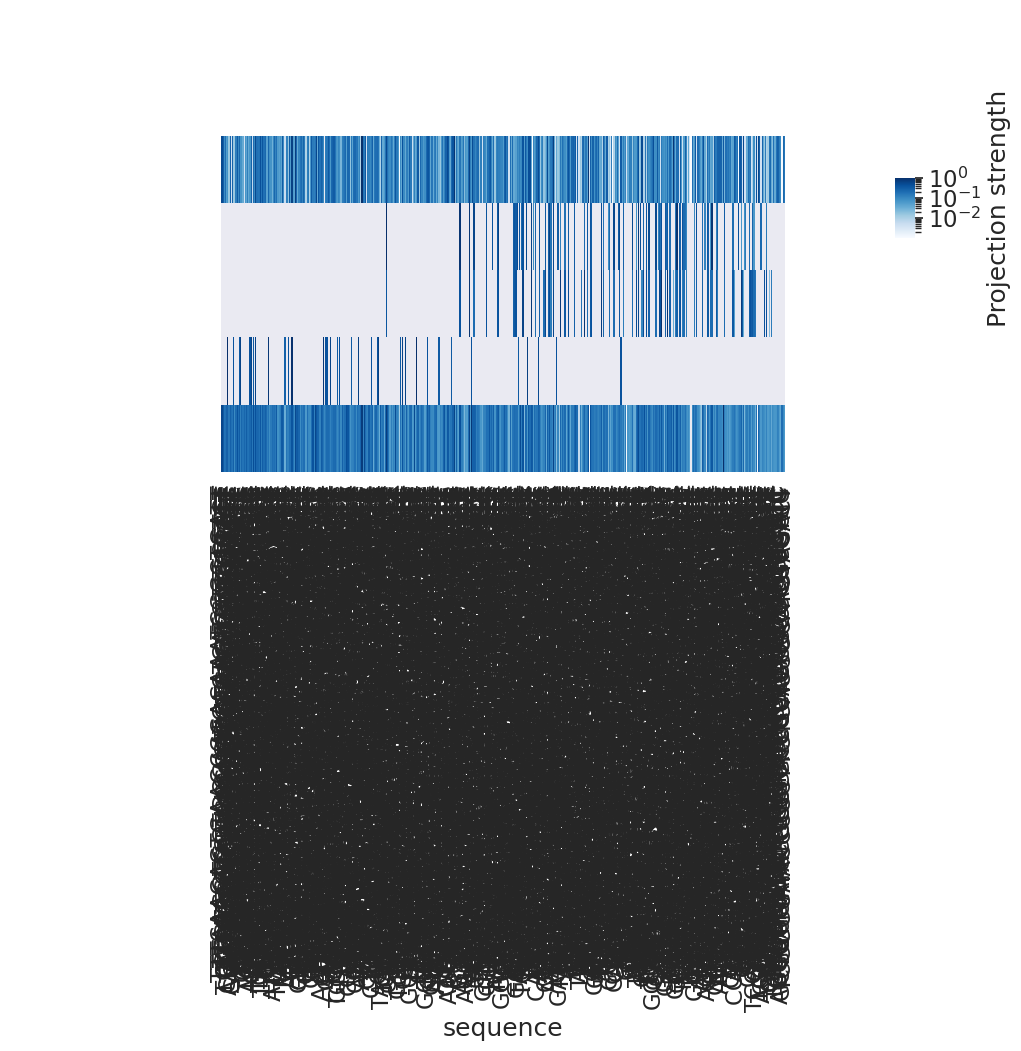

In [65]:
g = sb.clustermap(
    striatum_projecting.T,  # Transpose the data to rotate the plot by 90°
    metric="euclidean",
    standard_scale=0,
    norm=LogNorm(),
    cmap="Blues",
    figsize=(10, 6),  # Adjusted size to fit rotated plot
    xticklabels=True,
    yticklabels=False,
    cbar_pos=(1.01, 0.5, 0.02, 0.1),  # Reduced colorbar size
    cbar_kws={'label': 'Projection strength'},
    row_cluster=False,  # Remove row hierarchical clustering
    col_cluster=False   # Remove column hierarchical clustering
)

# Adjust the x-axis labels to rotate them if needed
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)

plt.show()

Text(0.5, 1.0, 'FIAA45.6a LCM ROI MAPseq barcode counts to anterograde tracing \n (r = 0.791, p = 6.62E-21)')

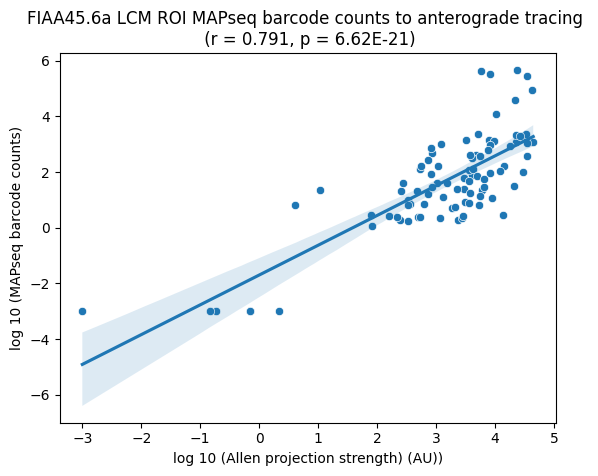

In [17]:

mouse = 'FIAA45.6a'
to_plot = pd.DataFrame()
to_plot['Allen'] = np.log10(allen_comp_dict[mouse]['Mean_Allen']+ 1e-3)
to_plot['MAPseq'] = np.log10(allen_comp_dict[mouse]['MAPseq_counts']+ 1e-3)
sb.scatterplot(
    data=to_plot,
    x="Allen",
    y="MAPseq",
    palette="ch:s=.25,rot=-.25",
)
sb.regplot(data=to_plot, x="Allen", y="MAPseq", scatter=False)
plt.xlabel("log 10 (Allen projection strength) (AU))")
plt.ylabel("log 10 (MAPseq barcode counts)")

corr, p = pearsonr(
    to_plot["Allen"], y=to_plot["MAPseq"]
)
plt.title(
    f"{mouse} LCM ROI MAPseq barcode counts to anterograde tracing \n (r = {np.round(corr, 3)}, p = {Decimal(p):.2E})"
)

In [20]:
blbl= to_plot.copy()

Text(0.5, 1.0, 'FIAA45.6d LCM ROI MAPseq barcode counts to anterograde tracing \n (r = 0.78, p = 8.33E-33)')

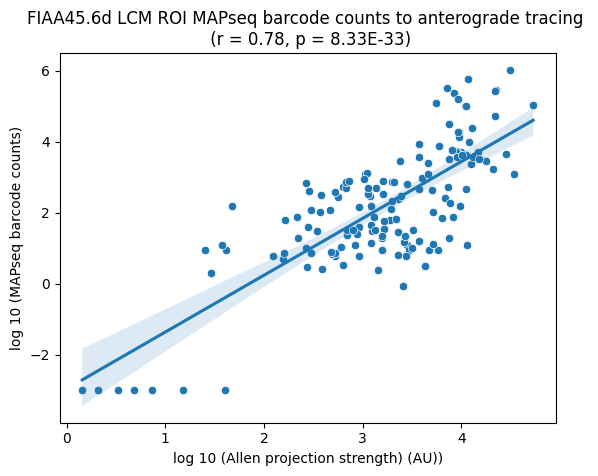

In [25]:

mouse = 'FIAA45.6d'
to_plot = pd.DataFrame()
to_plot['Allen'] = np.log10(allen_comp_dict[mouse]['Mean_Allen']+ 1e-3)
to_plot['MAPseq'] = np.log10(allen_comp_dict[mouse]['MAPseq_counts']+ 1e-3)
sb.scatterplot(
    data=to_plot,
    x="Allen",
    y="MAPseq",
    palette="ch:s=.25,rot=-.25",
)
sb.regplot(data=to_plot, x="Allen", y="MAPseq", scatter=False)
plt.xlabel("log 10 (Allen projection strength) (AU))")
plt.ylabel("log 10 (MAPseq barcode counts)")

corr, p = pearsonr(
    to_plot["Allen"], y=to_plot["MAPseq"]
)
plt.title(
    f"{mouse} LCM ROI MAPseq barcode counts to anterograde tracing \n (r = {np.round(corr, 3)}, p = {Decimal(p):.2E})"
)

In [32]:
allen_comp_dict['FIAA45.6a']

,Sample,Allen_expt_a,Allen_expt_b,Allen_expt_c,Mean_Allen,MAPseq_counts
0,2.0,69852.646900,10087.181956,53977.762041,44639.196966,1246.643678
1,5.0,28.828909,1.502921,2.101334,10.811055,23.440242
2,6.0,20518.472137,2206.048413,20383.831939,14369.450830,170.896535
3,17.0,236.250710,385.538397,140.257013,254.015374,21.166667
4,20.0,403.237243,675.979962,1080.888257,720.035154,15.838487
...,...,...,...,...,...,...
87,175.0,99.212512,44.576873,101.643095,81.810827,1.127793
88,177.0,0.450598,0.096725,0.000000,0.182441,0.000000
89,178.0,0.321607,0.000000,0.109478,0.143695,0.000000
90,179.0,1.994330,0.000000,0.140420,0.711583,0.000000


In [28]:
Allen_plot = pd.DataFrame()
Allen_plot['Allen_a'] = np.log10(allen_comp_dict[mouse]['Allen_expt_a']+ 1e-3)
Allen_plot['Allen_b'] = np.log10(allen_comp_dict[mouse]['Allen_expt_b']+ 1e-3)

In [36]:
np.log10(7)

0.8450980400142568

<AxesSubplot:xlabel='Allen', ylabel='MAPseq'>

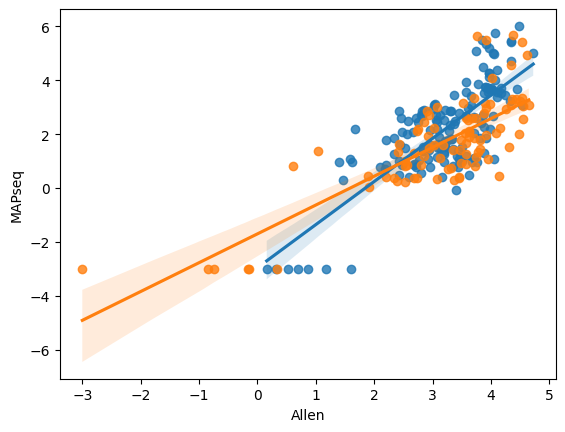

In [30]:
sb.regplot(data=to_plot, x="Allen", y="MAPseq", scatter=True)
sb.regplot(data=blbl, x="Allen", y="MAPseq", scatter=True)
#sb.regplot(data=Allen_plot, x="Allen_a", y="Allen_b", scatter=True)

In [10]:
allen_comp_dict[mouse][allen_comp_dict[mouse]['MAPseq_counts']<50]

,Sample,Allen_expt_a,Allen_expt_b,Allen_expt_c,Mean_Allen,MAPseq_counts
2,4.0,237.100290,253.102776,363.480865,284.561311,0.0
5,7.0,7.187819,149.305997,682.618255,279.704024,41.0
6,8.0,1174.885226,292.390113,1279.133606,915.469648,6.0
7,10.0,1.040106,3.253492,0.028514,1.440704,0.0
9,12.0,3651.793167,60.714573,2737.190874,2149.899538,0.0
...,...,...,...,...,...,...
167,186.0,40.977566,3.641686,0.856028,15.158427,0.0
168,187.0,12.469918,2.110284,0.000000,4.860067,0.0
169,188.0,17.436259,4.799636,0.000000,7.411965,0.0
170,189.0,0.017070,10.024868,0.000000,3.347312,0.0
